In [16]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import _pickle as pickle
import torch
from torch.utils.data import DataLoader
from pydub import AudioSegment

from train import load_hparams, load_model, load_checkpoint, make_aug_param_dictionary
from model import CnnEncoder
from data_utils import WindowedContourSet, ContourCollate, HummingPairSet
from melody_utils import MelodyDataset
from loss_function import SiameseLoss
from validation import get_contour_embeddings, cal_ndcg_single
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import IPython.display as ipd
import soundfile
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
def generate_sine_wav(melody, frame_rate=10, sr=44100):
    melody_resampled = np.repeat(melody, sr//frame_rate)
    phi = np.zeros_like(melody_resampled)
    phi[1:] = np.cumsum(2* np.pi * melody_resampled[:-1] / sr, axis=0)
    sin_wav = 0.6 * np.sin(phi)
    return sin_wav

def load_orig_audio_by_id(track_id, audio_path=Path('/home/svcapp/userdata/flo_data_backup/')):
    orig_audio_path = audio_path / track_id[:3] / track_id[3:6] / (track_id +'.aac')
    if not orig_audio_path.exists():
        orig_audio_path = orig_audio_path.with_suffix('.m4a')
    if not orig_audio_path.exists():
        orig_audio_path = audio_path / 'qbh' / (track_id + '.aac')
    orig_song = AudioSegment.from_file(orig_audio_path, 'm4a').set_channels(1).set_frame_rate(44100)._data
    orig_decoded = np.frombuffer(orig_song, dtype=np.int16) / 32768 
    return orig_decoded


def normalized_vec_to_orig(norm_contour, mean_pitch=61.702336487738215, std=5.5201786930065415):
    orig = np.zeros_like(norm_contour[:,0])
    orig[norm_contour[:,1]==1] = 440 * 2 ** ((norm_contour[norm_contour[:,1]==1, 0] * std + mean_pitch -69) / 12)
#     orig[norm_contour==-100] = 0
    return orig

In [3]:
with open('flo_metadata.dat', "rb") as f:
    meta = pickle.load(f)

In [8]:
song_ids = [x['song_id'] for x in meta[:8]]

In [64]:
dataset = WindowedContourSet('/home/svcapp/userdata/flo_data_backup/', [], song_ids)

100%|██████████| 8/8 [00:00<00:00, 30.03it/s]


In [10]:
dataset.contours[0]

{'contour': array([[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        ...,
        [0.41622992, 1.        ],
        [0.41622992, 1.        ],
        [0.41622992, 1.        ]]),
 'song_id': 427675,
 'frame_pos': (1500, 3500)}

In [19]:
old_dataset = WindowedContourSet('/home/svcapp/userdata/flo_data_backup/', [], song_ids)




  0%|          | 0/8 [00:00<?, ?it/s]


 25%|██▌       | 2/8 [00:00<00:00, 16.21it/s]


 50%|█████     | 4/8 [00:00<00:00, 16.05it/s]


 75%|███████▌  | 6/8 [00:00<00:00, 15.80it/s]


100%|██████████| 8/8 [00:00<00:00, 14.85it/s]


In [194]:
# [np.sum(np.abs(x['contour']-y['contour'])) for x, y in zip(dataset.contours, old_dataset.contours)]
[i  for i in range(len(dataset.contours)) if np.sum(np.abs(dataset.contours[i]['contour']-old_dataset.contours[i]['contour']))<500]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 34,
 35,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 124,
 127,
 196,
 202,
 213,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 292,
 293,
 294,
 295,
 296,
 297,
 304,
 305,
 306,
 307,
 316]

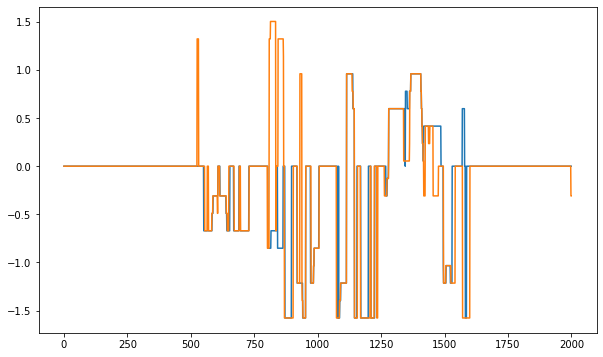

In [200]:
# idx = 61
idx = 13
plt.figure(figsize=(10,6))
plt.plot(dataset.contours[idx]['contour'][:,0])
plt.plot(old_dataset.contours[idx]['contour'][:,0])


In [201]:
selected_contour = dataset.contours[idx]
sr = 441
audio = load_orig_audio_by_id(str(selected_contour['song_id']))
orig_audio = audio[selected_contour['frame_pos'][0]*sr: selected_contour['frame_pos'][1]*sr]
sin_audio = generate_sine_wav(normalized_vec_to_orig(selected_contour['contour']), frame_rate=100)
ipd.Audio(orig_audio/8 + sin_audio/1.2, rate=44100)

In [202]:
selected_contour = old_dataset.contours[idx]
audio = load_orig_audio_by_id(str(selected_contour['song_id']))
orig_audio = audio[selected_contour['frame_pos'][0]*441: selected_contour['frame_pos'][1]*441]
sin_audio = generate_sine_wav(normalized_vec_to_orig(selected_contour['contour']), frame_rate=100)
ipd.Audio(orig_audio/8 + sin_audio/1.2, rate=44100)

In [111]:
selected_contour['frame_pos'][0]*441, selected_contour['frame_pos'][1]*441

(9040500, 9922500)

In [133]:
selected_contour

{'contour': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 'song_id': 433859135,
 'frame_pos': (0, 2000)}